### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_fbk_v1.csv"
df = pd.read_csv(dataset)



In [3]:
df["LargeText"] = df["LinkText"]+" "+df["Message"]

In [4]:
noticias = df.LargeText[df["tipo"].isin([2,3])]

len(noticias)

4552

In [5]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [6]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [7]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [8]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [9]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [10]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,10)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=200,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



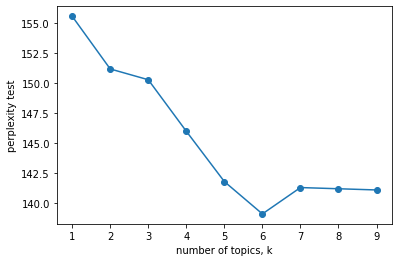

In [11]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [13]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=6,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [14]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=6
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['noticia', 'falso', 'coronavirus', 'desinformación', 'pandemia', 'persona', 'él', 'medio', 'año', 'chileno', 'generar', 'vacuna', 'salud', 'mundo', 'experto', 'crisis', 'estudio', 'tiempo', 'país', 'internet'], ['fake', 'new', 'empty', 'trump', 'video', 'desmentir', 'él', 'news', 'presidente', 'plebiscito', 'the', 'imagen', 'foto', 'donald', 'publicar', 'twitter', 'mandatario', 'periodista', 'cadena', 'clinic'], ['falso', 'información', 'noticia', 'incendio', 'entregar', 'difundir', 'pedir', 'caso', 'carabinero', 'haber', 'acusar', 'fiscalía', 'ex', 'gobierno', 'investigar', 'público', 'informe', 'forestal', 'denunciar', 'investigación'], ['desinformación', 'campaña', 'gobierno', 'bolsonaro', 'elección', 'año', 'país', 'político', 'brasil', 'política', 'electoral', 'proceso', 'empty', 'periodismo', 'presidente', 'proyecto', 'ley', 'acusar', 'buscar', 'nacional'], ['chile', 'fake', 'new', 'empty', 'kast', 'carrera', 'diputado', 'boric', 'acusar', 'gonzalo', 'falso', 'partido', 'vallej

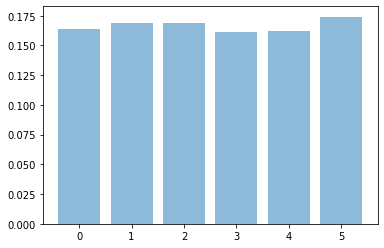

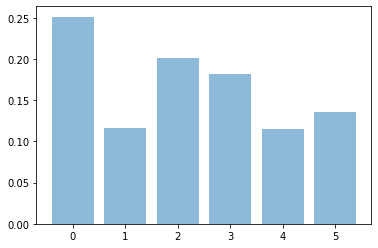

[0.07131408, 0.055116285, 0.04077085, 0.04006665, 0.029710473, 0.028960202, 0.02628645, 0.020884022, 0.019293264, 0.017991826, 0.017803349, 0.017657023, 0.017452836, 0.016270567, 0.014709269]


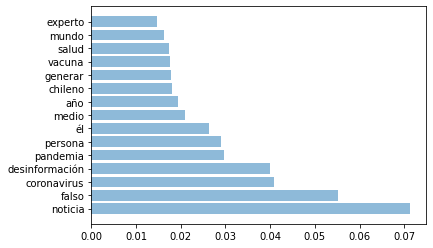

[0.23441081, 0.21972315, 0.040435996, 0.03373435, 0.030338962, 0.028132368, 0.022765303, 0.018184507, 0.015566194, 0.015431225, 0.014667564, 0.011908075, 0.011298319, 0.011162911, 0.010601529]


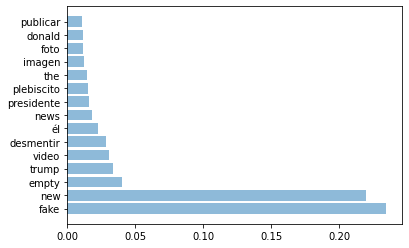

[0.15780097, 0.10926567, 0.06273508, 0.02665773, 0.022583036, 0.021645026, 0.021315325, 0.018892365, 0.015989238, 0.015038939, 0.01503635, 0.014944101, 0.013513094, 0.012310942, 0.011919038]


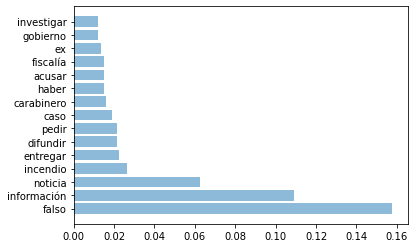

[0.08162659, 0.0429414, 0.027188526, 0.024662875, 0.024408692, 0.01866419, 0.01847119, 0.016612526, 0.016538704, 0.016479937, 0.016273718, 0.01604722, 0.015445124, 0.01509308, 0.014067037]


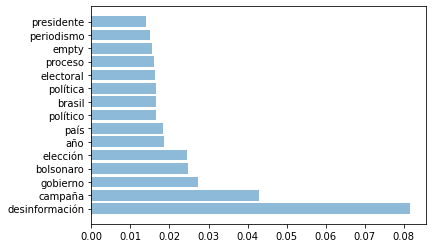

[0.06541238, 0.060783196, 0.05553295, 0.051524375, 0.03306121, 0.029657751, 0.029201878, 0.029113451, 0.027401654, 0.026682038, 0.0194788, 0.018361641, 0.01758768, 0.017366266, 0.014576643]


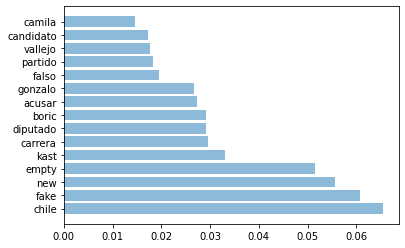

[0.12788723, 0.11213163, 0.11005975, 0.10186778, 0.04811946, 0.034996916, 0.03199586, 0.02681956, 0.022850879, 0.01804453, 0.01550642, 0.014306684, 0.012744783, 0.012449295, 0.011905258]


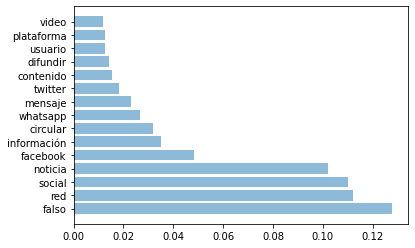

In [15]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [16]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [18]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

In [19]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)
print(etm_instance._perplexity(test_dataset))

0.09557121497737354
0.82
138.8


/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its